# Weight Initialization

## Kaiming Initialization

```text
- Kaiming initialization is based on the ReLU activation function. The ReLU activation function is a non-linear function that has the property of being zero when its input is negative. This means that the ReLU activation function can help to prevent the vanishing gradient problem, which is a problem that can occur when the weights of a neural network are too small.

- Kaiming initialization works by initializing the weights of a neural network to values that are drawn from a normal distribution with a mean of zero and a standard deviation that is equal to 2 / sqrt(n), where n is the number of inputs to the layer. This ensures that the weights of the neural network are initialized to values that are large enough to prevent the vanishing gradient problem, but not so large that they cause the exploding gradient problem.

- Kaiming initialization has been shown to improve the performance of neural networks on a variety of tasks, including image classification, natural language processing, and machine translation. It is a simple and effective method for initializing the weights of a neural network, and it is a good choice for most tasks.

- Default initialization technique used in PyTorch.

Advantages:
-----------
It can help to prevent the vanishing gradient problem.
It can help to prevent the exploding gradient problem.
It can improve the performance of neural networks on a variety of tasks.
```
<br>

## Xavier Initialization

```text
- Similar to Kaiming initialization, the goal of Xavier initialization is to address the challenges of training deep neural networks by ensuring that the variance of the activations and gradients remains stable during training. 

- Xavier initialization is specifically designed for activation functions that are linear or approximately linear around zero, such as tanh and logistic sigmoid.

- The Xavier initialization method initializes the weights of each layer by sampling values from a Gaussian distribution with a mean of zero and a standard deviation that is calculated based on the size of the input and output units. The standard deviation is given by:
```
$$std = \sqrt \frac {1}{(fan_{in} + fan_{out})}$$

```text
- It's worth noting that there are different variants of Xavier initialization, such as Xavier-Gaussian and Xavier-Uniform, which use different distribution types for weight initialization while maintaining the same underlying principles.

Advantages:
-----------
It can help to prevent the vanishing gradient problem.
It can help to prevent the exploding gradient problem.
It can improve the performance of neural networks on a variety of tasks.
```

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### How To Initialize The Weights With Kaiming/Xavier Initializations

In [2]:
class Net(nn.Module):
    """This is a simple FNN architecture."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(100, 100)
        self.hidden_1 = nn.Linear(100, 100)
        self.hidden_2 = nn.Linear(100, 100)
        self.hidden_3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 2)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden_1(X))
        X = F.relu(self.hidden_2(X))
        X = F.relu(self.hidden_3(X))
        return self.input(X)

In [3]:
# Create an instance of the model and extract the weights and biases
net = Net()
bias_arr, weight_arr = np.array([]), np.array([])

for param in net.named_parameters():
    if "bias" in param[0]:
        # Extract the bias, convert it from Torch to NumPy and concatenate
        bias_arr = np.concatenate([bias_arr, param[1].data.numpy().flatten()], axis=0)

    elif "weight" in param[0]:
        weight_arr = np.concatenate(
            [weight_arr, param[1].data.numpy().flatten()], axis=0
        )

In [4]:
# Total number of biases and weights
bias_arr.shape[0], weight_arr.shape[0]

(402, 40200)

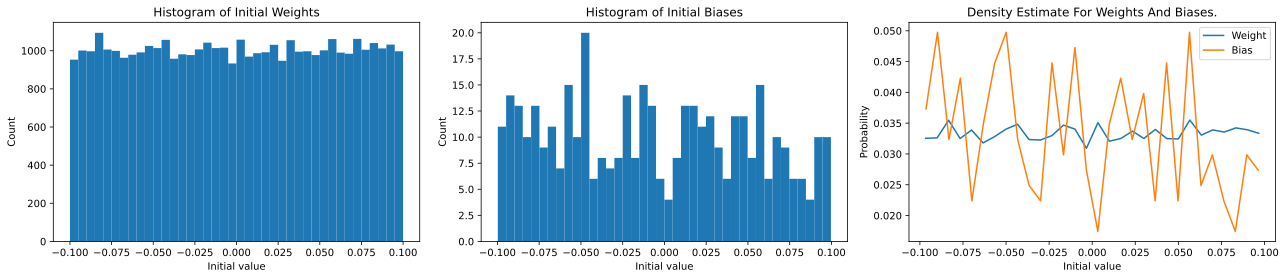

In [5]:
# Histogram of the weights and biaases
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].hist(weight_arr, bins=40)
ax[0].set_title("Histogram of Initial Weights")

ax[1].hist(bias_arr, bins=40)
ax[1].set_title("Histogram of Initial Biases")

# collect histogram data to show as line plots
yW, xW = np.histogram(weight_arr, bins=30)
yB, xB = np.histogram(bias_arr, bins=30)

# Density estimate
ax[2].plot((xW[1:] + xW[:-1]) / 2, yW / np.sum(yW), label="Weight")
ax[2].plot((xB[1:] + xB[:-1]) / 2, yB / np.sum(yB), label="Bias")
ax[2].set_title("Density Estimate For Weights And Biases.")
ax[2].legend()


# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")


plt.tight_layout()
plt.show()

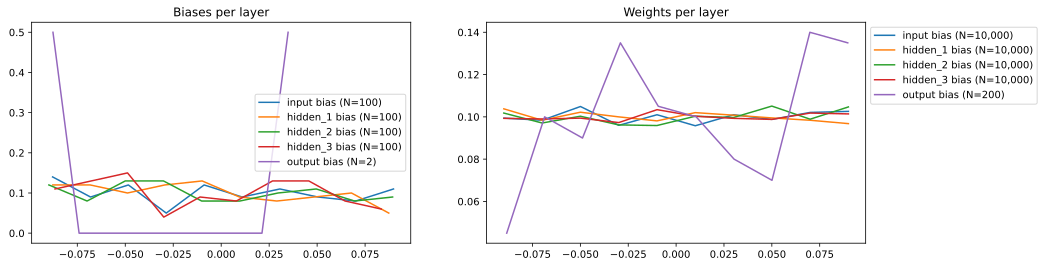

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for param in net.named_parameters():
    # Extract the data and compute their histogram
    data = param[1].data.numpy().flatten()
    y, x = np.histogram(data, 10)

    # Bias
    if "bias" in param[0]:
        ax[0].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label=f"{param[0][:-5]} bias (N={data.shape[0]:,})",
        )

    # Weights
    elif "weight" in param[0]:
        ax[1].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label=f"{param[0][:-7]} bias (N={data.shape[0]:,})",
        )


ax[0].set_title("Biases per layer")
ax[0].legend()
ax[1].set_title("Weights per layer")
ax[1].legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

#### Comment

##### Kaiming

$$\sigma = \sqrt{\frac{1}{N_{input}}}$$

```text
- Verify that the values of the weight match the formula.
```

In [7]:
# Verify that the numbers match our prediction from the formula

# Empirical bias range: Min and max bias value at the hidden layer 1
bias_range = [
    torch.min(net.hidden_1.bias.data).item(),
    torch.max(net.hidden_1.bias.data).item(),
]
bias_count = net.hidden_1.bias.data.shape[0]

# Theoretical expected value
sigma = np.sqrt(1 / bias_count)

# Validate
print(f"Theoretical sigma = {sigma}")
print(f"Empirical range = {bias_range}")

Theoretical sigma = 0.1
Empirical range = [-0.09748053550720215, 0.09706919640302658]


<hr><br><br>

#### Initialize The Weights With Xavier

In [8]:
# create a new instance of the model
net = Net()

# Change ONLY the weights.
for param in net.named_parameters():
    if "weight" in param[0]:
        nn.init.xavier_normal_(param[1].data)

# Empirical weight variance
weight_var = torch.var(net.hidden_1.weight.data.flatten()).item()
weight_count = net.hidden_1.weight.data.shape[0]

# Theoretical expected value
sigma_2 = 2 / (weight_count + weight_count)

print(f"Theoretical sigma = {sigma_2}")
print(f"Empirical range = {weight_var}")

Theoretical sigma = 0.01
Empirical range = 0.010032630525529385


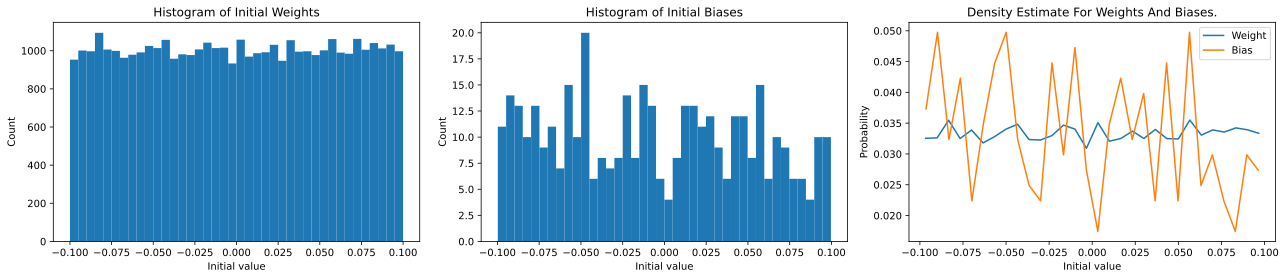

In [9]:
# Histogram of the weights and biaases
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].hist(weight_arr, bins=40)
ax[0].set_title("Histogram of Initial Weights")

ax[1].hist(bias_arr, bins=40)
ax[1].set_title("Histogram of Initial Biases")

# collect histogram data to show as line plots
yW, xW = np.histogram(weight_arr, bins=30)
yB, xB = np.histogram(bias_arr, bins=30)

# Density estimate
ax[2].plot((xW[1:] + xW[:-1]) / 2, yW / np.sum(yW), label="Weight")
ax[2].plot((xB[1:] + xB[:-1]) / 2, yB / np.sum(yB), label="Bias")
ax[2].set_title("Density Estimate For Weights And Biases.")
ax[2].legend()


# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")


plt.tight_layout()
plt.show()

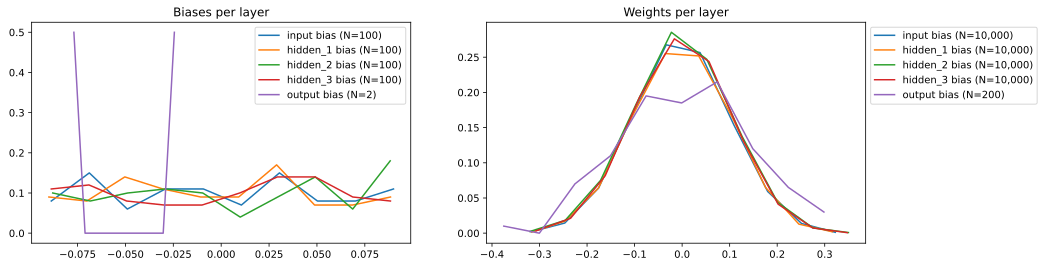

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for param in net.named_parameters():
    # Extract the data and compute their histogram
    data = param[1].data.numpy().flatten()
    y, x = np.histogram(data, 10)

    # Bias
    if "bias" in param[0]:
        ax[0].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label=f"{param[0][:-5]} bias (N={data.shape[0]:,})",
        )

    # Weights
    elif "weight" in param[0]:
        ax[1].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label=f"{param[0][:-7]} bias (N={data.shape[0]:,})",
        )


ax[0].set_title("Biases per layer")
ax[0].legend()
ax[1].set_title("Weights per layer")
ax[1].legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

### Train Models Using Kaiming And Xavier Weight Initializations.

In [11]:
fp = "../../data/wine_data.csv"
wine_data = load_data(filename=fp)

wine_data.head()

Shape of data: (1599, 12)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
# Select all the features bar the target.
X = wine_data.iloc[:, :-1]

# Normalize the data
norm_ = Normalizer(min_value=0, max_value=1)
X_norm = norm_.fit_transform(X=X)

X_norm.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846


In [13]:
# Binarize output
choice_list = [0, 1]

# 3, 4, and 5 : 0, else 1
wine_data["target"] = np.where(
    wine_data["quality"].isin(np.arange(3, 6)), choice_list[0], choice_list[1]
)

wine_data[["quality", "target"]].sample(5, random_state=5)

,quality,target
236,6,1
833,4,0
424,5,0
982,6,1
1155,5,0


In [14]:
# Convert to Tensors
X = torch.Tensor(X_norm.to_numpy())

# Requred by PyTorch to be 2D instead of 1D
y = torch.Tensor(wine_data["target"].to_numpy()).reshape(-1, 1)

# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([1279, 11]), torch.Size([320, 11]))

In [15]:
BATCH_SIZE, SHUFFLE = 32, True
DROP_LAST = True


# Create PyTorch datasets and dataloader objects.
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST
)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
)

In [16]:
# Build model architecture
class Net(nn.Module):
    """This is an ANN architecture that's used for regression."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(11, 32)
        self.hidden_1 = nn.Linear(32, 32)
        self.hidden_2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for the forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden_1(X))
        X = F.relu(self.hidden_2(X))
        X = self.output(X)
        return X


def train_model(
    *,
    net: Net,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
) -> tuple[list[float], list[float], list[float], Net]:
    """This is used to train the ANN model."""
    PCT = 100
    criterion = nn.BCEWithLogitsLoss()
    __optimizer__ = getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)
    train_accuracy, validation_accuracy, loss_accuracy = [], [], []

    for _ in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_pred = net(X_)
            loss: torch.Tensor = criterion(y_pred, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss and accuracy
            acc = torch.mean(((y_pred > 0) == y_).float()) * PCT
            batch_accuracy.append(acc.item())
            batch_loss.append(loss.item())

        # Training metrics
        train_accuracy.append(np.mean(batch_accuracy))
        loss_accuracy.append(np.mean(batch_loss))

        # Validation
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_pred_val = net(X_val)
        acc_ = torch.mean((y_val == (y_pred_val > 0)).float()) * PCT
        validation_accuracy.append(acc_.item())
    return (train_accuracy, validation_accuracy, loss_accuracy, net)

In [17]:
EPOCHS, LEARNING_RATE = 500, 0.01
OPTIMIZER_NAME, net_xavier = "Adam", Net()


# Change the weights (leave biases as Kaiming [default])
for param in net_xavier.named_parameters():
    if "weight" in param[0]:
        nn.init.xavier_normal_(param[1].data)

# Train the model
train_accuracy_X, validation_accuracy_X, loss_X, trained_net_xavier = train_model(
    net=net_xavier,
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

# Instantiate
net_kaiming = Net()

# Change the weights (leave biases as Kaiming [default])
for param in net_kaiming.named_parameters():
    if "weight" in param[0]:
        nn.init.kaiming_uniform_(param[1].data, nonlinearity="relu")

# Train the model
train_accuracy_K, validation_accuracy_K, loss_K, trained_net_kaiming_K = train_model(
    net=net_kaiming,
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

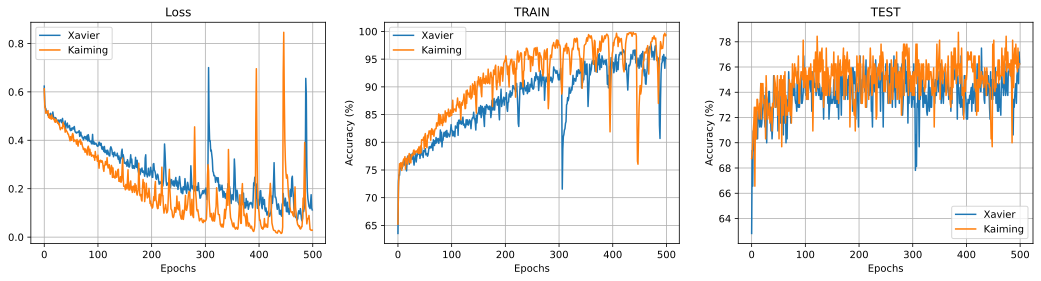

In [18]:
# Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# losses
ax[0].plot(loss_X, label="Xavier")
ax[0].plot(loss_K, label="Kaiming")
ax[0].set_title("Loss")

# train accuracy
ax[1].plot(train_accuracy_X, label="Xavier")
ax[1].plot(train_accuracy_K, label="Kaiming")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("TRAIN")

# test accuracy
ax[2].plot(validation_accuracy_X, label="Xavier")
ax[2].plot(validation_accuracy_K, label="Kaiming")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title("TEST")

for i in range(3):
    ax[i].legend()
    ax[i].grid("on")
    ax[i].set_xlabel("Epochs")


plt.show()

In [19]:
# Number of experiment iterations
NUM = 10


# Dimensions of results:
#  1 - experiment run
#  2 - metric (loss/train/test)
#  3 - weight init (Xavier/Kaiming)
results = np.zeros((NUM, 3, 2))


for idx in range(NUM):
    # ======== XAVIER ========
    net_xavier = Net()
    for param in net_xavier.named_parameters():
        if "weight" in param[0]:
            nn.init.xavier_normal_(param[1].data)

    # Train the model
    train_accuracy_X, validation_accuracy_X, losses_X, _ = train_model(
        net=net_xavier,
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        optimizer_name=OPTIMIZER_NAME,
    )

    # ======== KAIMING ========
    net_kaiming = Net()
    for param in net_kaiming.named_parameters():
        if "weight" in param[0]:
            nn.init.kaiming_uniform_(param[1].data, nonlinearity="relu")

    # Train the model
    train_accuracy_K, validation_accuracy_K, losses_K, _ = train_model(
        net=net_kaiming,
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        optimizer_name=OPTIMIZER_NAME,
    )

    # Record the results!
    results[idx, 0, 0] = np.mean(losses_X[-5:]).item()
    results[idx, 0, 1] = np.mean(losses_K[-5:]).item()

    results[idx, 1, 0] = np.mean(train_accuracy_X[-5:])
    results[idx, 1, 1] = np.mean(train_accuracy_K[-5:])

    results[idx, 2, 0] = np.mean(validation_accuracy_X[-5:])
    results[idx, 2, 1] = np.mean(validation_accuracy_K[-5:])

    print(f"Finished run {idx+1}/{NUM}")

Finished run 1/10
Finished run 2/10
Finished run 3/10
Finished run 4/10
Finished run 5/10
Finished run 6/10
Finished run 7/10
Finished run 8/10
Finished run 9/10
Finished run 10/10


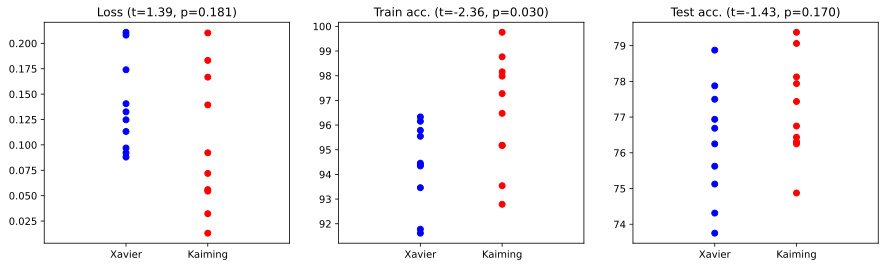

In [20]:
import scipy.stats as stats

# Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

metric = ["Loss", "Train acc.", "Test acc."]

for idx in range(3):
    # plot the results
    ax[idx].plot(np.zeros(NUM), results[:, idx, 0], "bo")
    ax[idx].plot(np.ones(NUM), results[:, idx, 1], "ro")

    # Run a t-test to formalize the comparison
    t, p = stats.ttest_ind(results[:, idx, 0], results[:, idx, 1])
    title = f"{metric[idx]} (t={t:.2f}, p={p:.3f})"

    ax[idx].set_xlim([-1, 2])
    ax[idx].set_xticks([0, 1])
    ax[idx].set_xticklabels(["Xavier", "Kaiming"])
    ax[idx].set_title(title)

plt.show()

## Weights Freezing

```text
-
-
```

In [21]:
fp = "../../data/mnist_digit/mnist_train.csv"
mnist_data = load_data(filename=fp)

mnist_data.head()

Shape of data: (60000, 785)



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,

In [22]:
X = mnist_data.iloc[:, 1:]
y = mnist_data.iloc[:, 0]

X.shape, y.shape, y.unique()

((60000, 784), (60000,), array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8]))

In [23]:
X.describe()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,27x21,

In [24]:
# Normalize data
X_norm = X / np.max(X)  # Since np.min(X) = 0

X_norm.describe()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,27x21,

In [25]:
BATCH_SIZE = 32

# Split data into train and validation sets
X_train, X_validation, y_train, y_validation = split_into_train_n_validation(
    data=X_norm, labels=y, convert_to_long=True
)

# Dataloader objects
train_DL, validation_DL = create_data_loader(
    X_train=X_train,
    X_validation=X_validation,
    y_train=y_train,
    y_validation=y_validation,
    batch_size=BATCH_SIZE,
)

[INFO]:: 2023-06-13 22:04:22,322:: X_train: torch.Size([48000, 784])
X_validation: torch.Size([12000, 784])



In [26]:
X.shape, y.nunique()

((60000, 784), 10)

In [27]:
# Build Model
class Net(nn.Module):
    """This is used to build a Feed Forward Network architecture that
    is used for classification."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(784, 32)
        self.hidden_1 = nn.Linear(32, 32)
        self.hidden_2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden_1(X))
        X = F.relu(self.hidden_2(X))
        X = torch.log_softmax(self.output(X), dim=1)
        return X

#### Freeze The Weights!

In [28]:
net = Net()

net.hidden_1.weight.requires_grad

True

In [29]:
net = Net()

# Switch off all layers except input
for param in net.named_parameters():
    if "input" not in param[0]:
        param[1].requires_grad = False


net.input.weight.requires_grad, net.hidden_1.weight.requires_grad

(True, False)

In [30]:
def train_model_freeze(
    *,
    net: Net,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, Net]:
    """This is used to train the FFN model with some of the weights frozen."""
    PCT = 100
    __optimizer__ = getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)

    # Negative log likelihood loss.
    # It is useful to train a classification problem with C classes.
    criterion = nn.NLLLoss()
    train_loss = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = (
        np.zeros(shape=(epochs,)),
        np.zeros(shape=(epochs,)),
    )

    print(f"Training epoch:")
    for epoch_idx in np.arange(epochs):
        
        # Switch off learning ONLY during the first 1/2 of training
        if epoch_idx < (epochs / 2):
            for param in net.named_parameters():
                if "output" not in param[0]:
                    param[1].requires_grad = False
        else:
            for param in net.named_parameters():
                param[1].requires_grad = True

        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

            batch_loss.append(loss.detach())

            # Backprop
            loss.backward()
            optimizer.step()

        # Train Metrics
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation Metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        y_pred_val = torch.argmax(y_proba_val, dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_
        if epoch_idx % 25 == 0:
            print(f"{epoch_idx} ", end="")

    return (train_accuracy, validation_accuracy, train_loss, net)

In [32]:
EPOCHS, LEARNING_RATE = 100, 0.01
OPTIMIZER_NAME, net = "SGD", Net()

train_accuracy, validation_accuracy, train_loss, trained_net = train_model_freeze(
    net=net,
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Training epoch:


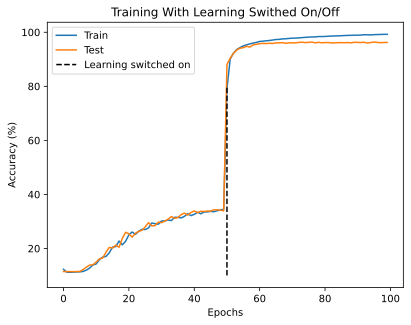

In [34]:
plt.plot(train_accuracy, label="Train")
plt.plot(validation_accuracy, label="Test")
plt.plot(
    [len(train_accuracy) / 2, len(train_accuracy) / 2],
    [10, 80],
    "k--",
    label="Learning switched on",
)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training With Learning Swithed On/Off")
plt.legend()
plt.show()